# Use case 2

### Comparing a pair of simiar continuous variables from GSV indicators and EPA Smart location database

## 1. Data Preparation

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from mgwr.gwr import GWR, MGWR, GWRResults
from mgwr.sel_bw import Sel_BW
from scipy import stats
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

scaler = StandardScaler()
%matplotlib inline



gsv = pd.read_csv('./data/gsv_indicators_summarized_county.csv')  # Google streetview Data
zipcode = pd.read_csv('./data/zip_code_database.csv')
census = pd.read_csv('./data/summary_zipcode_oct_1_2020.csv')
pedf = pd.read_csv('./data/ped_data.csv')
df = pd.read_csv('./data/ACSST1Y2021.S2504-Data.csv')   # ACS Census Data 2021

# df = df[['Geography', 'Geographic Area Name']]
# df['Geography'] = df['Geography'].str.split('S', expand=True)[1]
# df['Geography'] = df['Geography'].astype(int)

In [2]:
gsv = gsv.apply(lambda x: x * 100) 
gsv['county'] = gsv.county//100

In [3]:
gsv.head(2)

,county,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building
0,1001,96.914770,0.528769,8.930812,67.769762,0,34.387883,8.536476,8.397562
1,1003,94.701791,0.776435,11.609485,67.706725,0,43.614030,10.864435,9.718299


In [4]:
pedf.head(2)

,ID,pedestrian
0,1001,4.926896
1,1003,4.199844


#### Merge EPA Smart location data with GSV

In [5]:
# Merge EPA smart location data with GSV indicators

merged = gsv.merge(pedf, left_on='county', right_on='ID', how='inner')

#### Convert county FIPS to point {lat, lon}

In [6]:
merged

,county,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building,ID,pedestrian
0,1001,96.914770,0.528769,8.930812,67.769762,0,34.387883,8.536476,8.397562,1001,4.926896
1,1003,94.701791,0.776435,11.609485,67.706725,0,43.614030,10.864435,9.718299,1003,4.199844
2,1005,97.843315,0.444356,10.214536,66.514774,0,27.787841,4.338843,7.183290,1005,2.781773
3,1007,99.282113,0.209384,4.602171,73.284335,0,24.207333,3.559525,5.435433,1007,1.300386
4,1009,97.238618,0.266232,11.509886,67.439221,0,35.831923,3.221612,8.750568,1009,0.955175
...,...,...,...,...,...,...,...,...,...,...,...
1775,72137,79.443359,2.099609,39.990234,69.970703,0,65.087891,61.328125,32.861328,72137,18.477632
1776,72143,63.000000,4.000000,70.000000,38.000000,0,72.000000,54.000000,36.000000,72143,10.126148
1777,72145,63.200000,3.200000,72.800000,36.533333,0,69.066667,56.533333,45.066667,72145,12.882080
1778,72149,75.000000,0.000000,91.666667,25.000000,0,58.333333,100.000000,0.000000,72149,8.091481


In [7]:
import geopandas as gpd
from geopandas import GeoDataFrame

counties = gpd.read_file('https://cdn.jsdelivr.net/npm/us-atlas@3/counties-10m.json')\
                                                                            .sort_values(by='id').reset_index(drop=True)

empty = counties['geometry'].is_empty
counties_non_empty = counties[~empty]

In [8]:
counties_non_empty['lon'] = counties_non_empty['geometry'].centroid.x
counties_non_empty['lat'] = counties_non_empty['geometry'].centroid.y
counties_non_empty['id'] = counties_non_empty['id'].astype('int')
# counties_non_empty.head()

#### Merge all the dataframes to get a single df with all relevant features

In [9]:
data = merged.merge(counties_non_empty, left_on='county', right_on='id', how='inner')

In [10]:
data.drop(['ID', 'id', 'name'], axis=1, inplace=True)  # drop some irrelevant columns

In [11]:
# drop Hawaii and alaska
data.drop(data[(data.county >= 15000) & (data.county < 16000)].index, inplace=True)
data.drop(data[(data.county >= 2000) & (data.county < 4000)].index, inplace=True)

## 2. Modelling

#### Prepare data for GWR and LWCC

In [37]:
gdf = GeoDataFrame(data, crs="EPSG:4326")  # change the EPSG, see whether the result changes

gdf = gdf[(gdf.county >= 6000) & (gdf.county < 7000)]

# gdf.plot()
# gdf.shape

In [38]:
g_y = gdf['pedestrian'].values.reshape((-1,1))
g_X = gdf[['prop_sidewalk']].values

u = gdf['lon']
v = gdf['lat']

g_coords = list(zip(u,v))

#### Calculate LCC using the old algo `{standardize ---> weight}`

In [39]:
%%time

gwr_selector_o = Sel_BW(g_coords, g_y, g_X, lwcc=True)
gwr_bw_o = gwr_selector_o.search(bw_min=None)
print(gwr_bw_o)
gwr_results_o = GWR(g_coords, g_y, g_X, gwr_bw_o, lwcc=False).fit()  # Use fixed bandwidth of 25 for counties
gwr_results_o.summary()

I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I wa

#### GW - Correlation Coefficient -- From the [Book](https://www.academia.edu/33626785/Geographically_Weighted_Regression_The_Analysis_of_Spatially_Varying_Relationships_Wiley_2002)


$$
   \frac{(x_j - \overline x_i)(y_j - \overline y_i) w_ij}{w_ij\sqrt (x_j - \overline x_i)^2 . \sqrt (y_j - \overline y_i)^2 }\
$$

From Page 162-163 of [GWR - The analysis of spatially varying relationships](https://www.academia.edu/33626785/Geographically_Weighted_Regression_The_Analysis_of_Spatially_Varying_Relationships_Wiley_2002)



This result I got implementing the formula in the cells above was questionable, so I went ahead to extract the local collinearity method from the GWR codebase, pulled out the relevant function code and implemented it for two variables. `X` and `y` As such below

In [40]:
"""Local collinearity formula implementation. Extracted from MGWR codebase, line 1092, gwr.py, __author__ = Taylor Oshan"""

# x_scaled = scaler.fit_transform(x)
# y_scaled = scaler.fit_transform(y)


x_ = np.hstack((g_X, g_y))

def corr(cov):
    invsd = np.diag(1 / np.sqrt(np.diag(cov)))
    cors = np.dot(np.dot(invsd, cov), invsd)
    return cors

corr_mat = np.ndarray(shape=(len(x_), 1))


for i in range(len(x_)):
    wi_ = gwr_results_o.model._build_wi(i, gwr_bw_o)  
    sw = np.sum(wi_)
    wi_ = wi_/sw
    corr_mat[i] = corr(np.cov(x_[:, 0], x_[:, 1], aweights=wi_))[0][1]
    
corr_mat.mean(), corr_mat.min(), corr_mat.max()

(0.9192271188314669, 0.8983554315050467, 0.9285998549334085)

In [41]:
gdf['gwr_calc'] = corr_mat

#### Calculate LCC using the new algo `{weight ---> standardize}`

In [42]:
gwr_selector_n = Sel_BW(g_coords, g_y, g_X, lwcc=True)
gwr_bw_n = gwr_selector_n.search(bw_min=None)
print(gwr_bw_n)
gwr_results_n = GWR(g_coords, g_y, g_X, gwr_bw_n, constant=False, lwcc=True).fit() # Use fixed bandwidth of 25 for counties
gwr_results_n.summary()

I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I was used.
I wa

In [43]:
gdf['new_algo_params'] = gwr_results_n.params

In [44]:
import numpy as np 

def shift_colormap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero
    Parameters
    ----------
    cmap : The matplotlib colormap to be altered
    start : Offset from lowest point in the colormap's range.
      Defaults to 0.0 (no lower ofset). Should be between
      0.0 and `midpoint`.
    midpoint : The new center of the colormap. Defaults to
      0.5 (no shift). Should be between 0.0 and 1.0. In
      general, this should be  1 - vmax/(vmax + abs(vmin))
      For example if your data range from -15.0 to +5.0 and
      you want the center of the colormap at 0.0, `midpoint`
      should be set to  1 - 5/(5 + 15)) or 0.75
    stop : Offset from highets point in the colormap's range.
      Defaults to 1.0 (no upper ofset). Should be between
      `midpoint` and 1.0.
    
    Returns
    -------
    new_cmap : A new colormap that has been shifted. 
    '''

    import matplotlib as mpl
    import matplotlib.pyplot as plt

    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    new_cmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=new_cmap)

    return new_cmap

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    Function to truncate a colormap by selecting a subset of the original colormap's values
    Parameters
    ----------
    cmap : Mmatplotlib colormap to be altered
    minval : Minimum value of the original colormap to include in the truncated colormap
    maxval : Maximum value of the original colormap to include in the truncated colormap
    n : Number of intervals between the min and max values for the gradient of the truncated colormap
          
    Returns
    -------
    new_cmap : A new colormap that has been shifted. 
    '''

    import matplotlib as mpl

    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def compare_surfaces(data, var1, var2, savefig=None):
    '''
    Function that creates comparative visualization of GWR and MGWR surfaces.
    Parameters
    ----------
    data   : pandas or geopandas Dataframe
             gwr/mgwr results
    var1   : string
             name of gwr parameter estimate column in frame
    var2   : string
             name of mgwr parameter estimate column in frame
    gwr_t  : string
             name of gwr t-values column in frame associated with var1
    gwr_bw : float
             bandwidth for gwr model for var1
    mgwr_t : string
             name of mgwr t-values column in frame associated with var2
    mgwr_bw: float
             bandwidth for mgwr model for var2
    name   : string
             common variable name to use for title
    kwargs1:
             additional plotting arguments for gwr surface
    kwargs2:
             additional plotting arguments for mgwr surface
    savefig: string, optional
             path to save the figure. Default is None. Not to save figure.
    '''
    import matplotlib.pyplot as plt
    import geopandas as gp
    

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45, 38))
    ax0 = axes[0]
    ax0.set_title('Improved GW CC', fontsize=40)
    ax1 = axes[1]
    ax1.set_title('Classic GW CC', fontsize=40)

    #Set color map
    cmap = plt.cm.seismic

    #Find min and max values of the two combined datasets
    improved_min = data[var1].min()
    improved_max = data[var1].max()
    classic_min = data[var2].min()
    classic_max = data[var2].max()
    vmin = np.min([improved_min, classic_min])
    vmax = np.max([improved_max, classic_max])
    #If all values are negative use the negative half of the colormap
    if (vmin < 0) & (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)
    #If all values are positive use the positive half of the colormap
    elif (vmin > 0) & (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    #Otherwise, there are positive and negative values so the colormap so zero is the midpoint
    else:
        cmap = shift_colormap(cmap, start=0.0,
                              midpoint=1 - vmax / (vmax + abs(vmin)), stop=1.)

    #Create scalar mappable for colorbar and stretch colormap across range of data values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
        vmin=vmin, vmax=vmax))

    #Plot GWR parameters
    data.plot(var1, cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax)


    #Plot MGWR parameters
    data.plot(var2, cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax)


    #Set figure options and plot
#     fig.tight_layout()
    fig.subplots_adjust(right=0.9)
    cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=50)
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

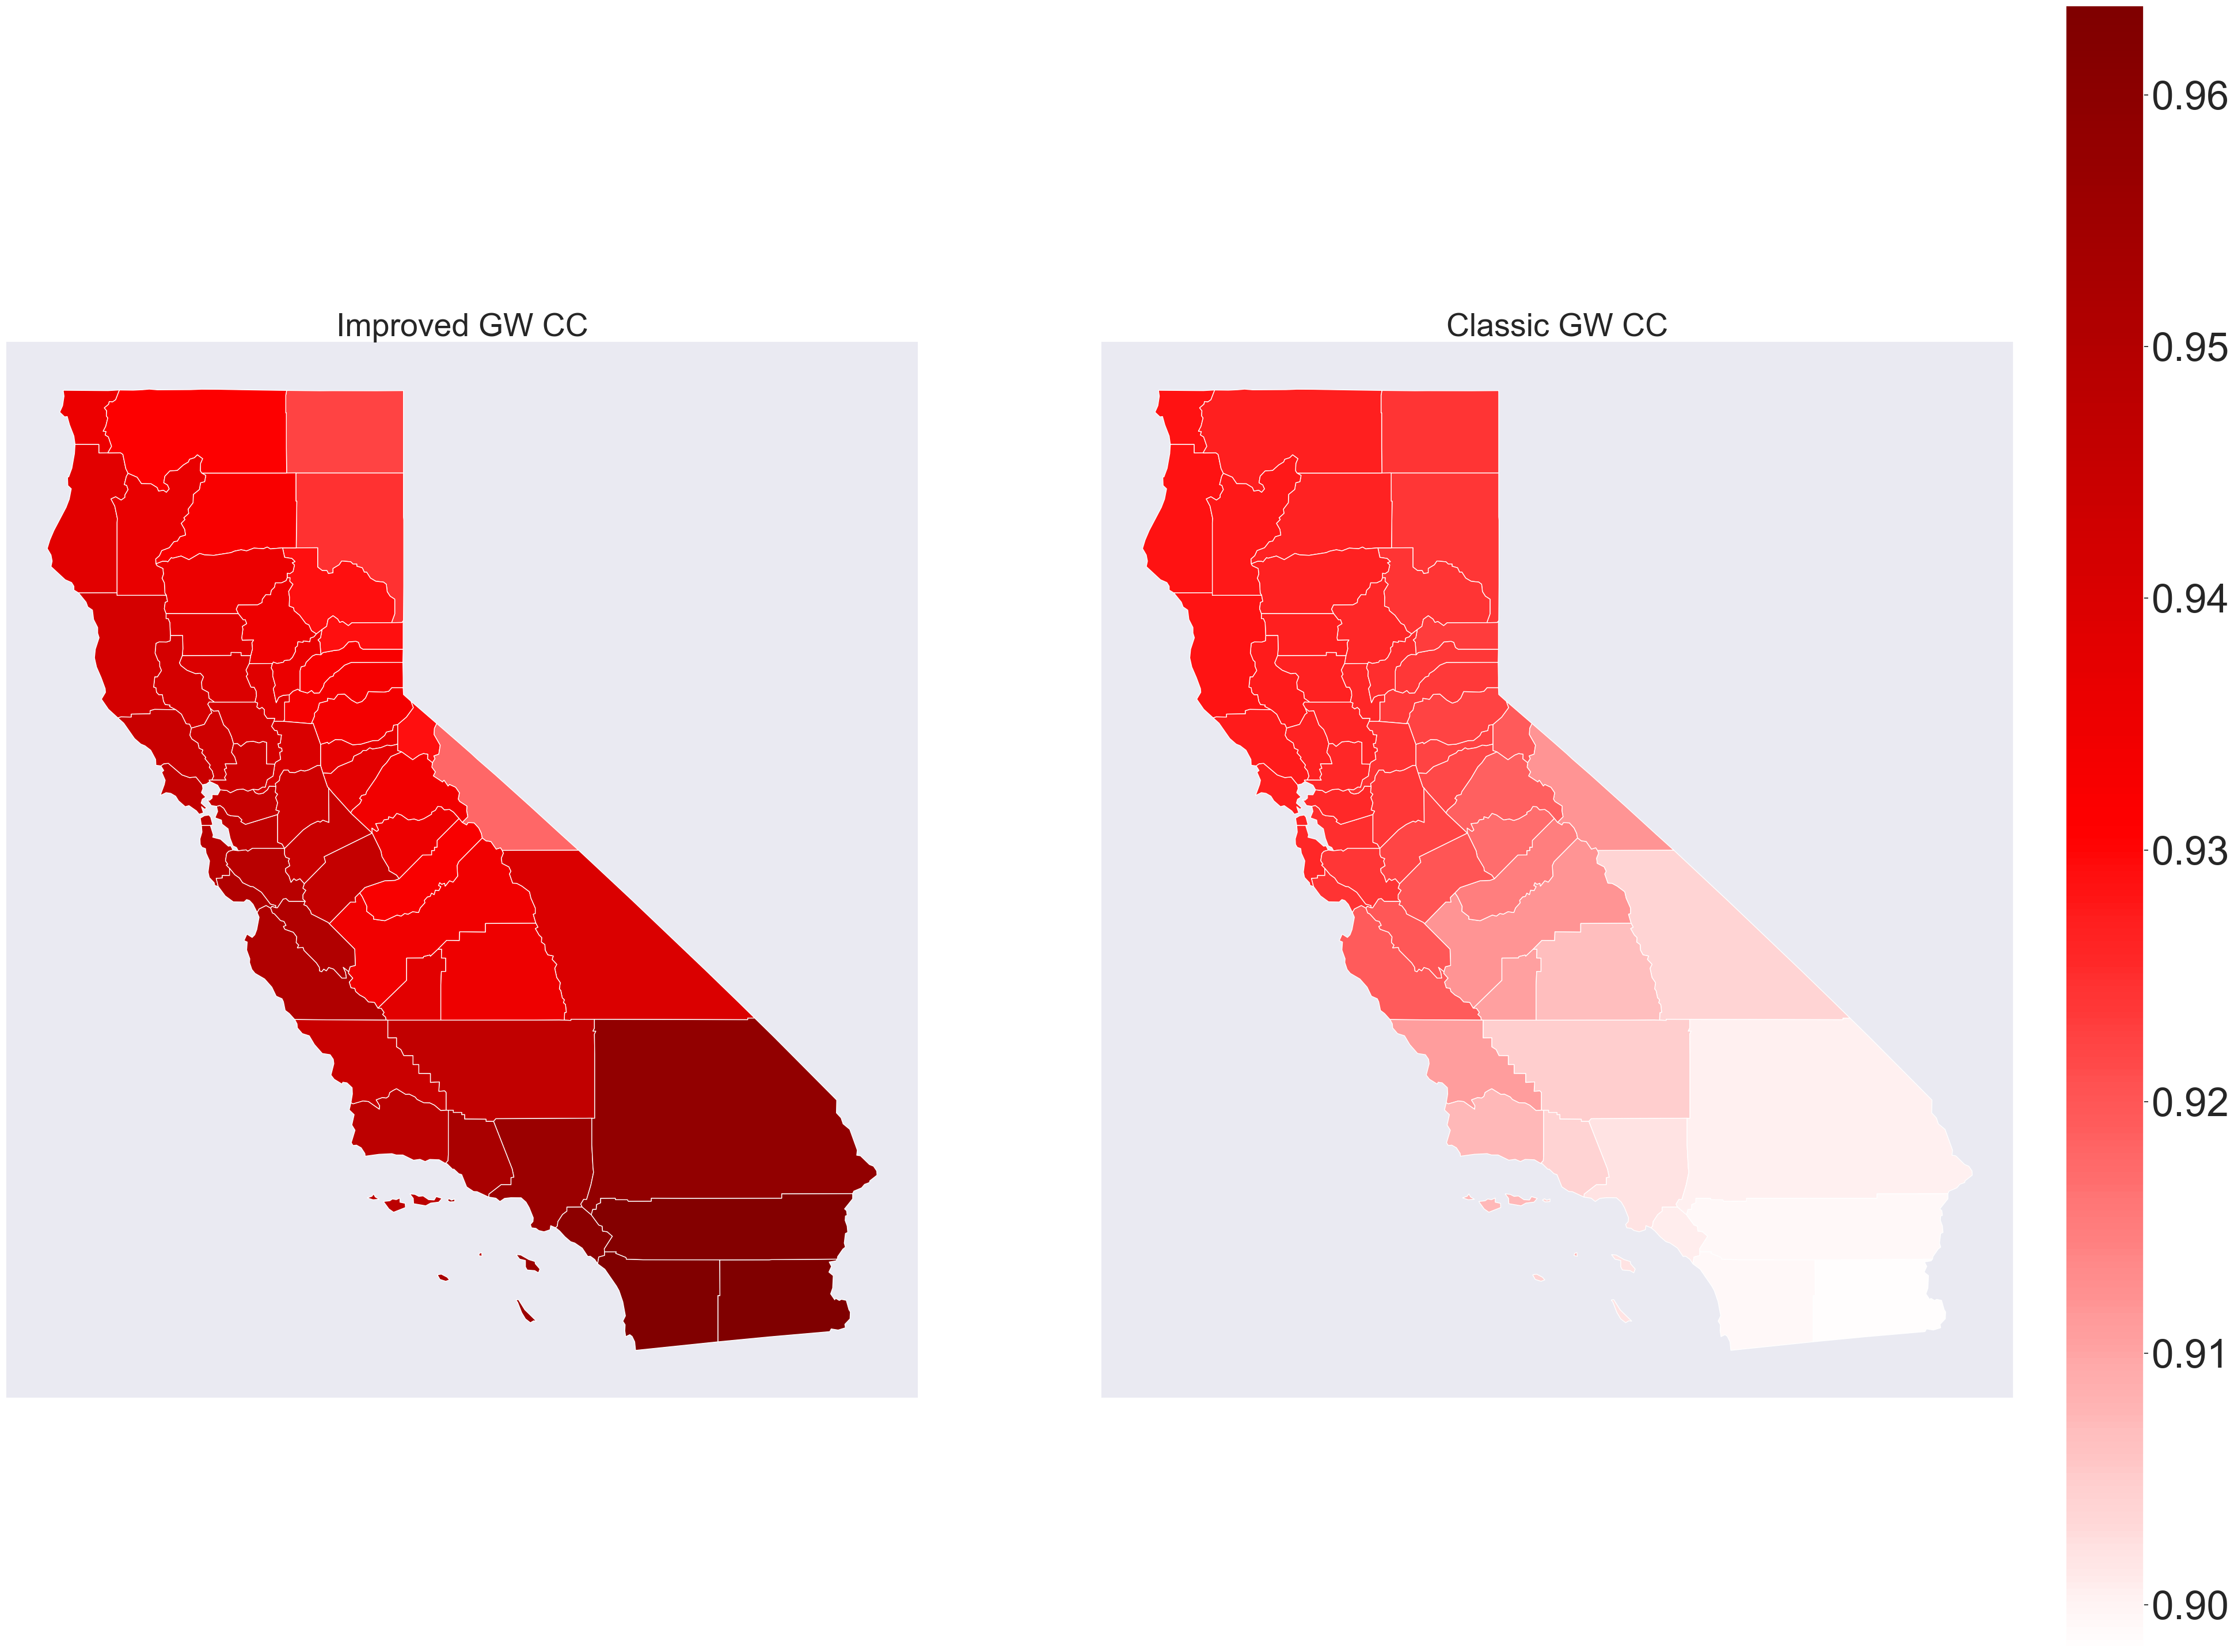

In [45]:
# from utils import compare_surfaces

compare_surfaces(gdf, 'new_algo_params', 'gwr_calc', savefig='./figs/lwcc_improved_algo/use-case 2/cali-county.png')

#### Locally weightedPeason's r Independently calculated

In [21]:
corr = []

for i in range(len(g_X)):
    wi = gwr_results_o.model._build_wi(i, gwr_bw_n).reshape(-1,1)
    xw = g_X*wi
    yw = g_y*wi
    corr_coef, _ = stats.pearsonr(yw.flatten(), xw.flatten())
    corr.append(corr_coef)

np.array(corr).mean()

0.941291801937129

#### Global correlation coefficient

In [22]:
corr_g = []
corr_coef, _ = stats.pearsonr(g_X.flatten(), g_y.flatten())
corr_g.append(corr_coef)
corr_g

[0.9165987545980158]

#### Global Regression

In [23]:
# import statsmodels.api as sm
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# # xi =  g_X - g_X.mean(axis=0) / g_X.std(axis=0)
# # yi =  g_y - g_y.mean(axis=0) / g_y.std(axis=0)


# xi = scaler.fit_transform(g_X)
# yi = scaler.fit_transform(g_y)

# sm_results = sm.OLS(yi, xi).fit()

# sm_results.params

#### [Old Algo] Keep a random variable as the y for local_collinearity() 

In [24]:
# data['apartments'] = data['apartments'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
# data = data.dropna()

# for i in state_list:
#     print(i, merged[merged['co_name'].str.contains(i)].shape[0])
# #     print(i)

# data = data[data['co_name'].str.contains('Florida')]
# print(data.shape[0])
# gdf = GeoDataFrame(data, crs="EPSG:4326")  # change the EPSG, see whether the result changes

# gdf.plot()

# newJersey = data[data['co_name'].str.contains('Maryland')]
# newJersey.drop('co_name', axis=1, inplace=True)
# # data.drop('co_name', axis=1, inplace=True)


# state_list = ['Alabama', 'Alaska', 'Arizona',
# 'Arkansas',
# 'California',
# 'Colorado',
# 'Connecticut',
# 'Delaware',
# 'Florida',
# 'Georgia',
# 'Hawaii',
# 'Idaho',
# 'Illinois',
# 'Indiana',
# 'Iowa',
# 'Kansas',
# 'Kentucky',
# 'Louisiana',
# 'Maine',
# 'Maryland',
# 'Massachusetts',
# 'Michigan',
# 'Minnesota',
# 'Mississippi',
# 'Missouri',
# 'Montana',
# 'Nebraska',
# 'Nevada',
# 'New Hampshire',
# 'New Jersey',
# 'New Mexico',
# 'New York',
# 'North Carolina',
# 'North Dakota',
# 'Ohio',
# 'Oklahoma',
# 'Oregon',
# 'Pennsylvania',
# 'Rhode Island',
# 'South Carolina',
# 'South Dakota',
# 'Tennessee',
# 'Texas',
# 'Utah',
# 'Vermont',
# 'Virginia',
# 'Washington',
# 'West Virginia',
# 'Wisconsin',
# 'Wyoming']